In [1]:
print("\033[1mHPC Project Team 6\033[0m")


HPC Project Team 6


In [2]:
print("\033[1m Data Preprocessing \033[0m")


 Data Preprocessing 


Training Data Samples:
Class: melanoma


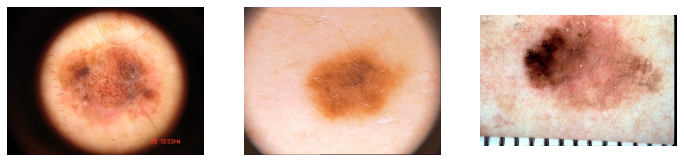

Class: nevus


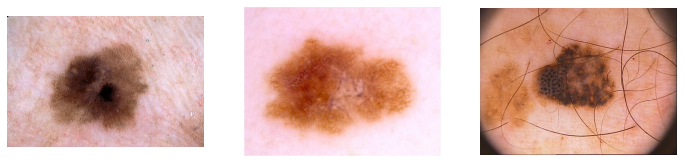

Class: seborrheic_keratosis


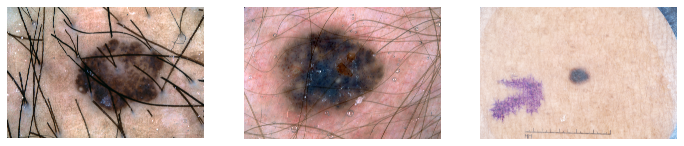


Validation Data Samples:
Class: melanoma


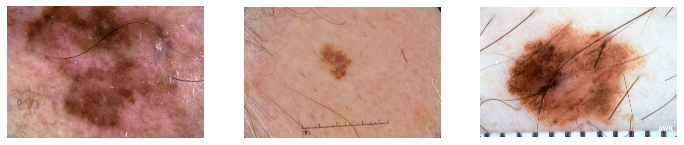

Class: nevus


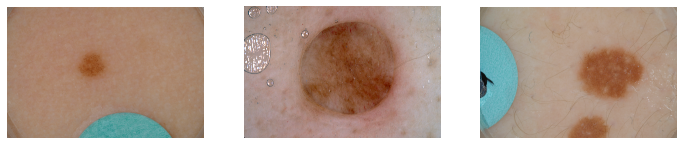

Class: seborrheic_keratosis


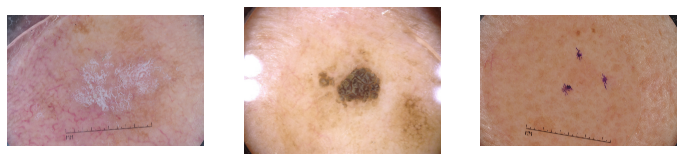


Test Data Samples:
Class: melanoma


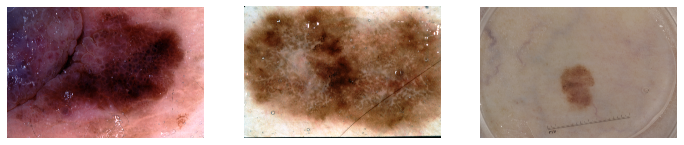

Class: nevus


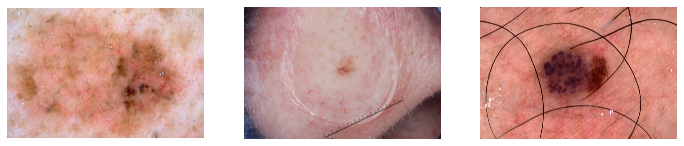

Class: seborrheic_keratosis


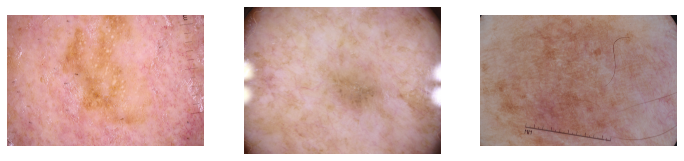

In [3]:
import os
import matplotlib.pyplot as plt
import random
from PIL import Image

# Define dataset directories
data_dir = '/home/mudavadkar.g/HPC-Project'
train_dir = os.path.join(data_dir, 'train')
valid_dir = os.path.join(data_dir, 'valid')
test_dir = os.path.join(data_dir, 'test')

# Function to display 3 sample images from each class
def show_sample_images(dataset_dir, num_samples=3):
    # Get all class names (subdirectories in dataset_dir)
    class_names = os.listdir(dataset_dir)
    
    # Loop over each class
    for class_name in class_names:
        class_dir = os.path.join(dataset_dir, class_name)
        
        # Check if it is a directory (in case there are files outside of class directories)
        if os.path.isdir(class_dir):
            print(f"Class: {class_name}")
            
            # Get all image filenames in the class directory
            image_files = os.listdir(class_dir)
            
            # Randomly sample 'num_samples' images
            sample_images = random.sample(image_files, num_samples)
            
            # Set up a subplot with 1 row and 'num_samples' columns
            plt.figure(figsize=(12, 4))
            
            for i, image_file in enumerate(sample_images):
                image_path = os.path.join(class_dir, image_file)
                
                # Open the image using PIL
                img = Image.open(image_path)
                
                # Display image in subplot
                plt.subplot(1, num_samples, i+1)
                plt.imshow(img)
                plt.axis('off')  # Turn off axis labels
                
            # Show the images for this class
            plt.show()

# Show sample images from training, validation, and testing datasets
print("Training Data Samples:")
show_sample_images(train_dir)

print("\nValidation Data Samples:")
show_sample_images(valid_dir)

print("\nTest Data Samples:")
show_sample_images(test_dir)


Train Dataset:
  melanoma: 374 images
  nevus: 1372 images
  seborrheic_keratosis: 254 images
Valid Dataset:
  melanoma: 30 images
  nevus: 78 images
  seborrheic_keratosis: 42 images
Test Dataset:
  melanoma: 117 images
  nevus: 393 images
  seborrheic_keratosis: 90 images

Total number of images in the dataset: 2750


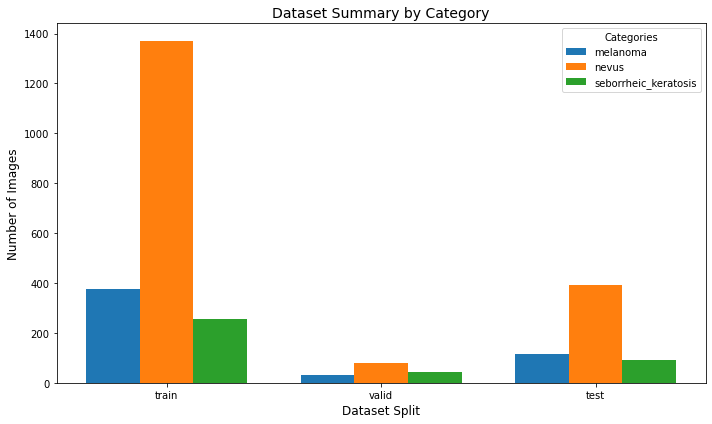

In [4]:
import os
import matplotlib.pyplot as plt

def summarize_dataset(data_dir):
    """
    Summarizes the number of images in each subdirectory for the dataset.
    
    Args:
        data_dir (str): Path to the dataset directory containing 'train', 'valid', and 'test' folders.
    
    Returns:
        dict: A dictionary summarizing the counts for each category in each dataset split.
    """
    summary = {}
    total_images = 0  # Counter for total images

    # Loop through train, valid, and test directories
    for split in ['train', 'valid', 'test']:
        split_dir = os.path.join(data_dir, split)
        category_counts = {}
        
        # Loop through each category in the split (melanoma, nevus, seborrheic keratosis)
        for category in os.listdir(split_dir):
            category_dir = os.path.join(split_dir, category)
            if os.path.isdir(category_dir):
                # Count the number of files in the category directory
                num_images = len([f for f in os.listdir(category_dir) if os.path.isfile(os.path.join(category_dir, f))])
                category_counts[category] = num_images
                total_images += num_images  # Increment total images
        
        summary[split] = category_counts

    summary['total_images'] = total_images  # Add total image count to the summary
    return summary

def plot_summary(summary):
    """
    Plots a summary of the dataset in a bar chart.
    
    Args:
        summary (dict): Dictionary summarizing the dataset.
    """
    splits = [key for key in summary.keys() if key != 'total_images']  # Exclude 'total_images'
    categories = list(summary[splits[0]].keys())

    # Prepare data for plotting
    category_data = {category: [] for category in categories}
    for split in splits:
        for category in categories:
            category_data[category].append(summary[split].get(category, 0))

    # Plotting
    bar_width = 0.25
    x = range(len(splits))
    plt.figure(figsize=(10, 6))

    for i, (category, counts) in enumerate(category_data.items()):
        plt.bar([p + i * bar_width for p in x], counts, width=bar_width, label=category)

    # Adding labels and legends
    plt.xlabel('Dataset Split', fontsize=12)
    plt.ylabel('Number of Images', fontsize=12)
    plt.title('Dataset Summary by Category', fontsize=14)
    plt.xticks([p + bar_width for p in x], splits)
    plt.legend(title="Categories")
    plt.tight_layout()
    plt.show()


# Main code
data_dir = '/home/mudavadkar.g/HPC-Project'

# Summarize the dataset
dataset_summary = summarize_dataset(data_dir)

# Print the summary
for split, counts in dataset_summary.items():
    if split != 'total_images':
        print(f"{split.capitalize()} Dataset:")
        for category, count in counts.items():
            print(f"  {category}: {count} images")

# Print the total number of images in the dataset
print(f"\nTotal number of images in the dataset: {dataset_summary['total_images']}")

# Plot the summary
plot_summary(dataset_summary)


In [5]:
print("\033[1m Image Enhancement Uisng DASK For Data Parallelism \033[0m")


 Image Enhancement Uisng DASK For Data Parallelism 


In [6]:
import os
import cv2
from dask import delayed, compute
from dask.diagnostics import ProgressBar
import time
import matplotlib.pyplot as plt

# Define dataset directories
data_dir = '/home/mudavadkar.g/HPC-Project'
train_dir = os.path.join(data_dir, 'train')
valid_dir = os.path.join(data_dir, 'valid')
test_dir = os.path.join(data_dir, 'test')

# New enhanced dataset base directory
enhance_data_dir = os.path.join(data_dir, 'Enhanced_Images')

def segment_lesion(image):
    """Enhance and segment the lesion in the image."""
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray, (5, 5), 0)
    _, thresh = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    return thresh

@delayed
def process_and_save_image(img_path, src_base_dir, dest_base_dir):
    """Process and save enhanced images to the new directory structure."""
    img = cv2.imread(img_path)
    if img is None:
        return f"Error loading {img_path}"
    
    enhanced_img = segment_lesion(img)
    
    relative_path = os.path.relpath(img_path, src_base_dir)
    dest_path = os.path.join(dest_base_dir, relative_path)
    
    os.makedirs(os.path.dirname(dest_path), exist_ok=True)
    
    cv2.imwrite(dest_path, enhanced_img)
    return f"Saved {dest_path}"

def count_and_enhance_images(split_dir, dest_dir):
    summary = {}
    total_images = 0
    tasks = []

    for category in os.listdir(split_dir):
        category_dir = os.path.join(split_dir, category)
        if os.path.isdir(category_dir):
            num_images = len([f for f in os.listdir(category_dir) if os.path.isfile(os.path.join(category_dir, f))])
            summary[category] = num_images
            total_images += num_images  

            for file_name in os.listdir(category_dir):
                file_path = os.path.join(category_dir, file_name)
                if os.path.isfile(file_path):
                    tasks.append(process_and_save_image(file_path, split_dir, dest_dir))

    return tasks, total_images

# Function to run Dask with a specified number of CPUs
def run_dask_with_cpus(cpus):
    start_time = time.time()

    # Limit the number of workers (CPUs) for Dask
    from dask.distributed import Client
    client = Client(n_workers=cpus)

    # Process the dataset (train, valid, and test)
    summary = {}
    for split, src_dir in zip(['train', 'valid', 'test'], [train_dir, valid_dir, test_dir]):
        dest_dir = os.path.join(enhance_data_dir, split)
        tasks, total_images = count_and_enhance_images(src_dir, dest_dir)
        with ProgressBar():
            compute(*tasks)

    elapsed_time = time.time() - start_time
    client.close()  # Close the Dask client
    return elapsed_time

# Record times for different numbers of CPUs
cpu_counts = [1, 4, 6, 8]
elapsed_times = []
for cpus in cpu_counts:
    print(f"Running with {cpus} CPUs...")
    elapsed_time = run_dask_with_cpus(cpus)
    elapsed_times.append(elapsed_time)

# Speedup and efficiency calculations
base_time = elapsed_times[0]  # Time with 1 CPU as the base
speedups = [base_time / time for time in elapsed_times]
efficiencies = [speedup / cpus for speedup, cpus in zip(speedups, cpu_counts)]



Running with 1 CPUs...
Running with 4 CPUs...
Running with 6 CPUs...
Running with 8 CPUs...


Enhanced Training Data Samples:
Class: melanoma


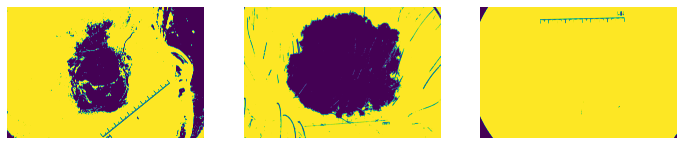

Class: nevus


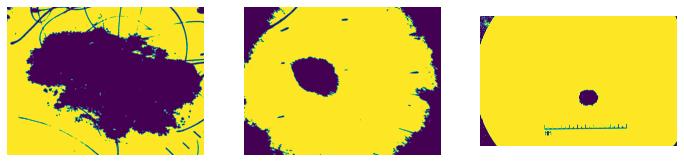

Class: seborrheic_keratosis


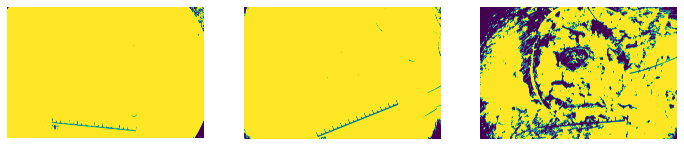


Enhanced Validation Data Samples:
Class: melanoma


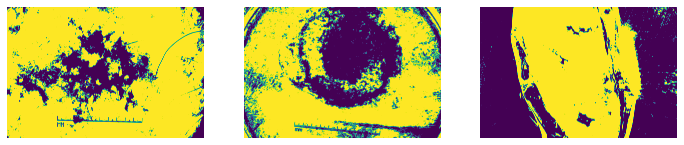

Class: nevus


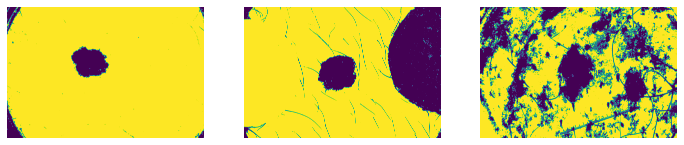

Class: seborrheic_keratosis


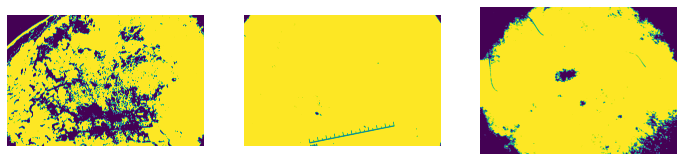


Enhanced Test Data Samples:
Class: melanoma


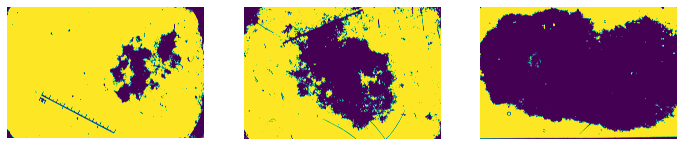

Class: nevus


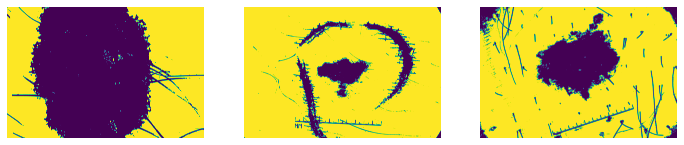

Class: seborrheic_keratosis


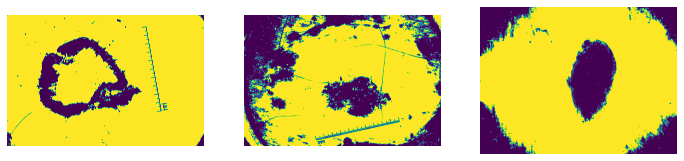

In [7]:
import os
import matplotlib.pyplot as plt
import random
from PIL import Image

# Define dataset directories
data_dir = '/home/mudavadkar.g/HPC-Project/Enhanced_Images'
train_dir = os.path.join(data_dir, 'train')
valid_dir = os.path.join(data_dir, 'valid')
test_dir = os.path.join(data_dir, 'test')

# Function to display 3 sample images from each class
def show_sample_images(dataset_dir, num_samples=3):
    # Get all class names (subdirectories in dataset_dir)
    class_names = os.listdir(dataset_dir)
    
    # Loop over each class
    for class_name in class_names:
        class_dir = os.path.join(dataset_dir, class_name)
        
        # Check if it is a directory (in case there are files outside of class directories)
        if os.path.isdir(class_dir):
            print(f"Class: {class_name}")
            
            # Get all image filenames in the class directory
            image_files = os.listdir(class_dir)
            
            # Randomly sample 'num_samples' images
            sample_images = random.sample(image_files, num_samples)
            
            # Set up a subplot with 1 row and 'num_samples' columns
            plt.figure(figsize=(12, 4))
            
            for i, image_file in enumerate(sample_images):
                image_path = os.path.join(class_dir, image_file)
                
                # Open the image using PIL
                img = Image.open(image_path)
                
                # Display image in subplot
                plt.subplot(1, num_samples, i+1)
                plt.imshow(img)
                plt.axis('off')  # Turn off axis labels
                
            # Show the images for this class
            plt.show()

# Show sample images from training, validation, and testing datasets
print("Enhanced Training Data Samples:")
show_sample_images(train_dir)

print("\nEnhanced Validation Data Samples:")
show_sample_images(valid_dir)

print("\nEnhanced Test Data Samples:")
show_sample_images(test_dir)


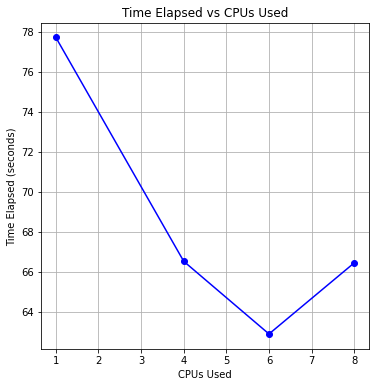

In [8]:
plt.figure(figsize=(20, 6))  # Increase the figure size (width, height)

# Time Elapsed vs CPUs Used
plt.subplot(131)
plt.plot(cpu_counts, elapsed_times, marker='o', color='b')
plt.title('Time Elapsed vs CPUs Used')
plt.xlabel('CPUs Used')
plt.ylabel('Time Elapsed (seconds)')
plt.grid(True)

# Show the plot with increased size

plt.show()


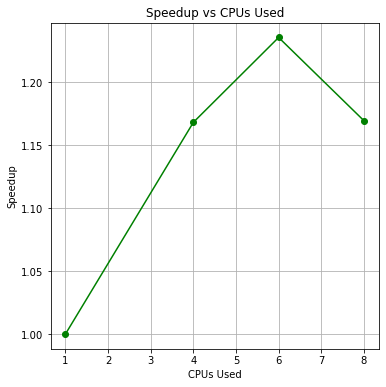

In [9]:
plt.figure(figsize=(20, 6))  # Increase the figure size (width, height)
# Speedup vs CPUs Used
plt.subplot(132)
plt.plot(cpu_counts, speedups, marker='o', color='g')
plt.title('Speedup vs CPUs Used')
plt.xlabel('CPUs Used')
plt.ylabel('Speedup')
plt.grid(True)
plt.show()

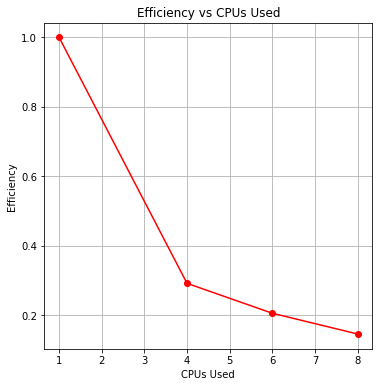

In [10]:
# Efficiency vs CPUs Used
plt.figure(figsize=(20, 6))  
plt.subplot(133)
plt.plot(cpu_counts, efficiencies, marker='o', color='r')
plt.title('Efficiency vs CPUs Used')
plt.xlabel('CPUs Used')
plt.ylabel('Efficiency')
plt.grid(True)

In [11]:
import platform

# Get CPU architecture details
cpu_info = platform.processor()  # Returns the name of the processor
architecture = platform.architecture()  # Returns a tuple with architecture details

print(f"CPU Info: {cpu_info}")
print(f"Architecture: {architecture}")

CPU Info: x86_64
Architecture: ('64bit', 'ELF')


In [12]:
!nvidia-smi

Sun Dec  1 19:48:13 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.82.01    Driver Version: 470.82.01    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:84:00.0 Off |                    0 |
| N/A   31C    P0    59W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla K80           Off  | 00000000:85:00.0 Off |                    0 |
| N/A   

In [13]:
print("\033[1m Model Prallelism Using DDP \033[0m")


 Model Prallelism Using DDP 


In [14]:
output_text = """
Running Distributed Data Parallel (DDP) training directly in a Jupyter Notebook is not feasible due to its single-process nature. When trying to use DDP in the notebook, we encountered a `RuntimeError: Cannot re-initialize CUDA in forked subprocess`. Even after setting the start method to 'spawn' using `torch.set_start_method('spawn')`, the issue persisted. This happens because Jupyter executes code in the `__main__` module, and when using the 'spawn' method, the child processes start a new Python interpreter where the `train_model()` function is not available.

To fix this, we created a separate Python script (`ddptrainutils.py`) that includes the DDP logic, such as initializing the process group, setting up the data loader, and training the model. This script allows us to run the DDP training across multiple GPUs.

We then used Bash to execute this Python script, leveraging the computing resources for distributed training.
"""

print(output_text)



Running Distributed Data Parallel (DDP) training directly in a Jupyter Notebook is not feasible due to its single-process nature. When trying to use DDP in the notebook, we encountered a `RuntimeError: Cannot re-initialize CUDA in forked subprocess`. Even after setting the start method to 'spawn' using `torch.set_start_method('spawn')`, the issue persisted. This happens because Jupyter executes code in the `__main__` module, and when using the 'spawn' method, the child processes start a new Python interpreter where the `train_model()` function is not available.

To fix this, we created a separate Python script (`ddptrainutils.py`) that includes the DDP logic, such as initializing the process group, setting up the data loader, and training the model. This script allows us to run the DDP training across multiple GPUs.

We then used Bash to execute this Python script, leveraging the computing resources for distributed training.



In [15]:
output_text = """Since our DDP implementation runs on a Python script, we store the outputs in a file. The outputs, including epoch, last learning rate, training loss, validation loss, and validation accuracy for each GPU, are saved in JSON format. The output for various number of GPU is stored in respective number of GPU json file. We then read the data from these respective JSON files to plot the graphs."""
print(output_text)


Since our DDP implementation runs on a Python script, we store the outputs in a file. The outputs, including epoch, last learning rate, training loss, validation loss, and validation accuracy for each GPU, are saved in JSON format. The output for various number of GPU is stored in respective number of GPU json file. We then read the data from these respective JSON files to plot the graphs.


In [17]:
print("\033[1m Various Metrices Plots using 1 GPU \033[0m")


 Various Metrices Plots using 1 GPU 


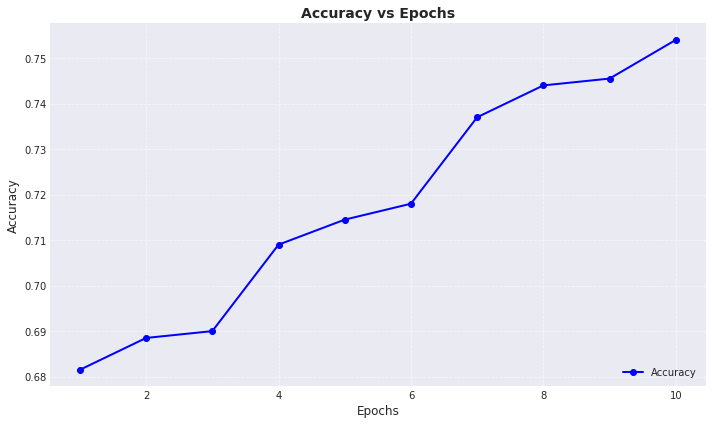

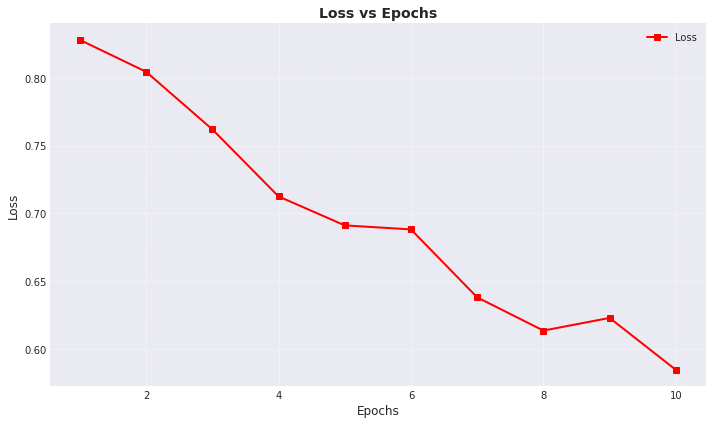

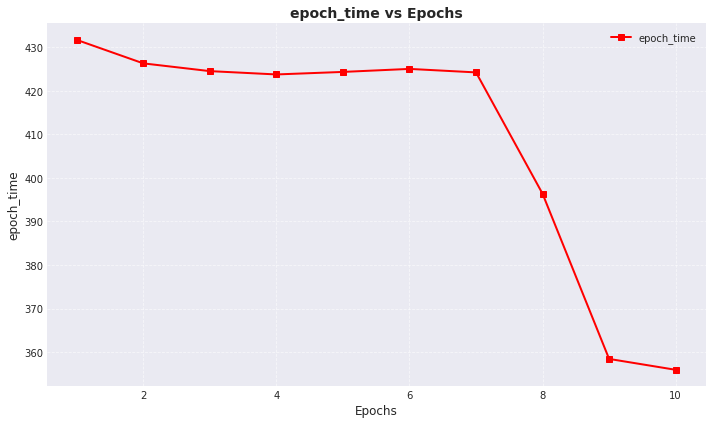

In [18]:
import json
import matplotlib.pyplot as plt
 
# Load the training metrics from the log file
with open('training_metrics_1gpu.json', 'r') as f:
    logs = [json.loads(line) for line in f]
 
# Extract the metrics
epochs = [log['epoch'] for log in logs]
losses = [log['loss'] for log in logs]
accuracies = [log['accuracy'] for log in logs]
epoch_time = [log['epoch_time'] for log in logs]
 
# Define a common style for all plots
plt.style.use('seaborn-darkgrid')  # Choose a neat style
 
# Plot Accuracy vs Epochs
plt.figure(figsize=(10, 6))
plt.plot(epochs, accuracies, label='Accuracy', color='blue', linewidth=2, marker='o')
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.title('Accuracy vs Epochs', fontsize=14, weight='bold')
plt.legend(loc='lower right', fontsize=10)
plt.grid(True, linestyle='--', alpha=0.6)  # Add gridlines
plt.tight_layout()  # Adjust layout to fit everything neatly
plt.show()
 
# Plot Loss vs Epochs
plt.figure(figsize=(10, 6))
plt.plot(epochs, losses, label='Loss', color='red', linewidth=2, marker='s')
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.title('Loss vs Epochs', fontsize=14, weight='bold')
plt.legend(loc='upper right', fontsize=10)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# Plot epoch_time vs epoch


plt.figure(figsize=(10, 6))
plt.plot(epochs, epoch_time, label='epoch_time', color='red', linewidth=2, marker='s')
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('epoch_time', fontsize=12)
plt.title('epoch_time vs Epochs', fontsize=14, weight='bold')
plt.legend(loc='upper right', fontsize=10)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


In [19]:
print("\033[1m Various Metrices Plots using 2 GPU \033[0m")


 Various Metrices Plots using 2 GPU 


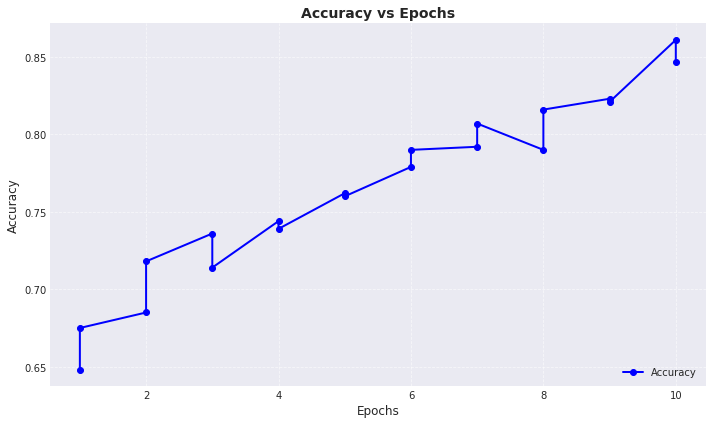

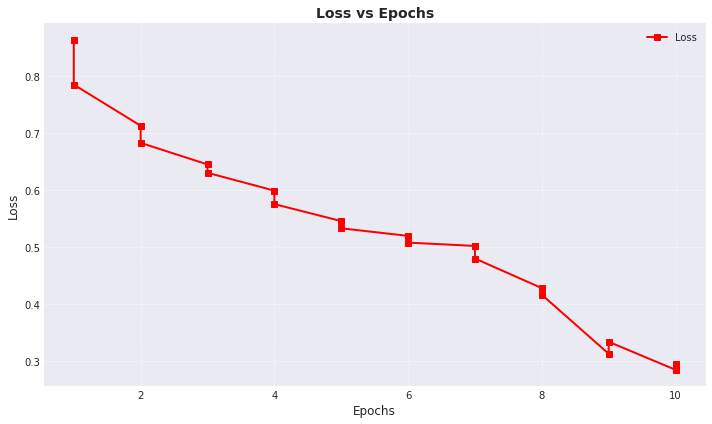

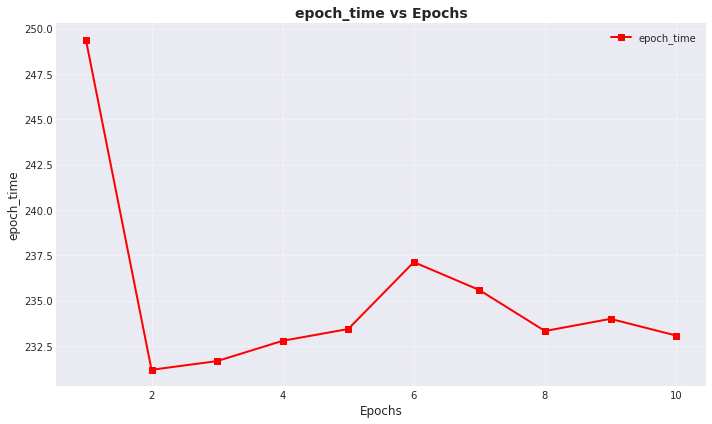

In [20]:
import json
import matplotlib.pyplot as plt
 
# Load the training metrics from the log file
with open('training_metrics_GPU_2.json', 'r') as f:
    logs = [json.loads(line) for line in f]
 
# Extract the metrics
epochs = [log['epoch'] for log in logs]
losses = [log['loss'] for log in logs]
accuracies = [log['accuracy'] for log in logs]
epoch_time = [log['epoch_time'] for log in logs]
 
# Define a common style for all plots
plt.style.use('seaborn-darkgrid')  # Choose a neat style
 
# Plot Accuracy vs Epochs
plt.figure(figsize=(10, 6))
plt.plot(epochs, accuracies, label='Accuracy', color='blue', linewidth=2, marker='o')
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.title('Accuracy vs Epochs', fontsize=14, weight='bold')
plt.legend(loc='lower right', fontsize=10)
plt.grid(True, linestyle='--', alpha=0.6)  # Add gridlines
plt.tight_layout()  # Adjust layout to fit everything neatly
plt.show()
 
# Plot Loss vs Epochs
plt.figure(figsize=(10, 6))
plt.plot(epochs, losses, label='Loss', color='red', linewidth=2, marker='s')
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.title('Loss vs Epochs', fontsize=14, weight='bold')
plt.legend(loc='upper right', fontsize=10)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# Plot epoch_time vs epoch


plt.figure(figsize=(10, 6))
plt.plot(epochs, epoch_time, label='epoch_time', color='red', linewidth=2, marker='s')
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('epoch_time', fontsize=12)
plt.title('epoch_time vs Epochs', fontsize=14, weight='bold')
plt.legend(loc='upper right', fontsize=10)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


In [21]:
print("\033[1m Various Metrices Plots using 4 GPU \033[0m")


 Various Metrices Plots using 4 GPU 


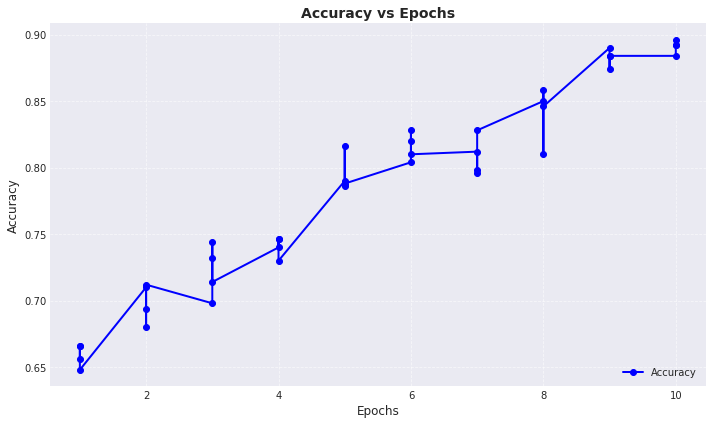

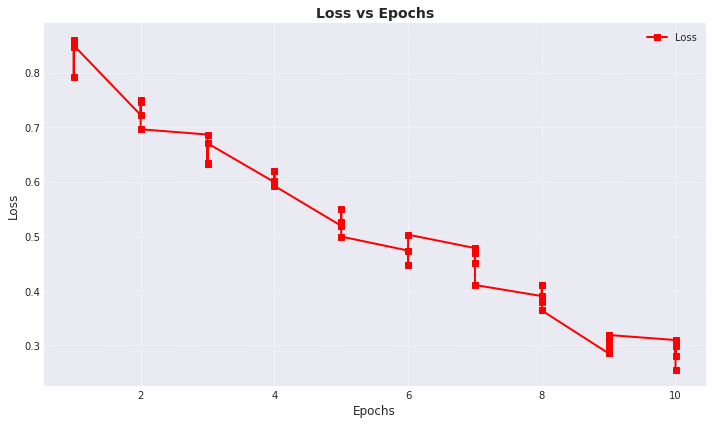

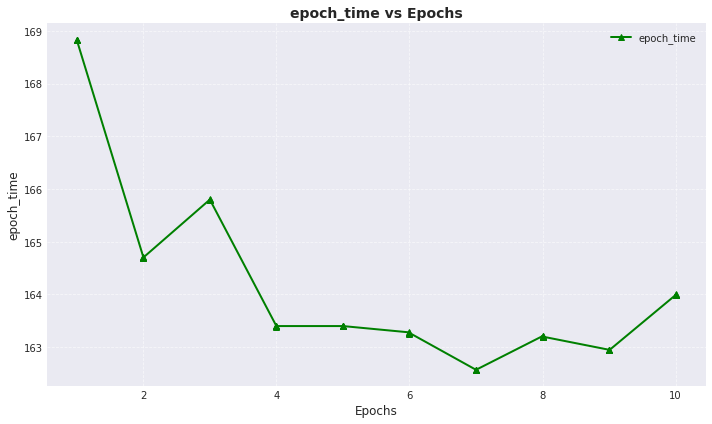

In [22]:
import json
import matplotlib.pyplot as plt

# Initialize an empty list to store parsed logs
logs = []

# Load the training metrics from the log file
with open('training_metrics_GPU4.json', 'r') as f:
    for line in f:
        line = line.strip()  # Remove leading/trailing whitespace and newlines
        if line:  # Only process non-empty lines
            try:
                logs.append(json.loads(line))  # Parse each line as a separate JSON object
            except json.JSONDecodeError as e:
                print(f"Error parsing line: {line}. Error: {e}")

# Extract the metrics
epochs = [log['epoch'] for log in logs]
losses = [log['loss'] for log in logs]
accuracies = [log['accuracy'] for log in logs]
epoch_time = [log['epoch_time'] for log in logs]

# Define a common style for all plots
plt.style.use('seaborn-darkgrid')  # Choose a neat style

# Plot Accuracy vs Epochs
plt.figure(figsize=(10, 6))
plt.plot(epochs, accuracies, label='Accuracy', color='blue', linewidth=2, marker='o')
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.title('Accuracy vs Epochs', fontsize=14, weight='bold')
plt.legend(loc='lower right', fontsize=10)
plt.grid(True, linestyle='--', alpha=0.6)  # Add gridlines
plt.tight_layout()  # Adjust layout to fit everything neatly
plt.show()

# Plot Loss vs Epochs
plt.figure(figsize=(10, 6))
plt.plot(epochs, losses, label='Loss', color='red', linewidth=2, marker='s')
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.title('Loss vs Epochs', fontsize=14, weight='bold')
plt.legend(loc='upper right', fontsize=10)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# Plot epoch_time vs epoch
plt.figure(figsize=(10, 6))
plt.plot(epochs, epoch_time, label='epoch_time', color='green', linewidth=2, marker='^')
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('epoch_time', fontsize=12)
plt.title('epoch_time vs Epochs', fontsize=14, weight='bold')
plt.legend(loc='upper right', fontsize=10)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


In [23]:
print("\033[1m Various Metrices Plots Comparision of 1 VS 2 VS 4 GPU \033[0m")


 Various Metrices Plots Comparision of 1 VS 2 VS 4 GPU 


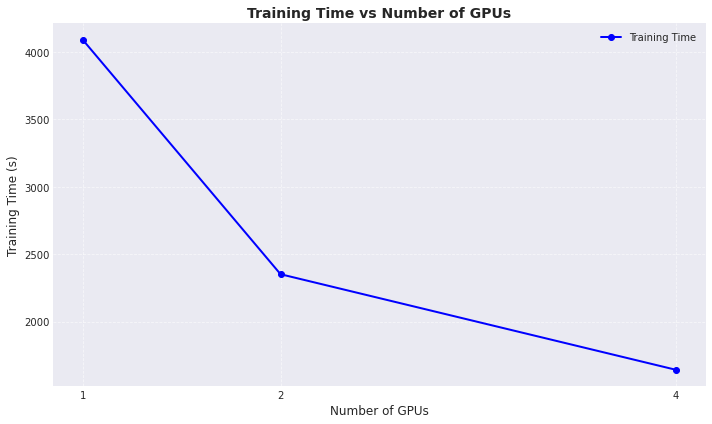

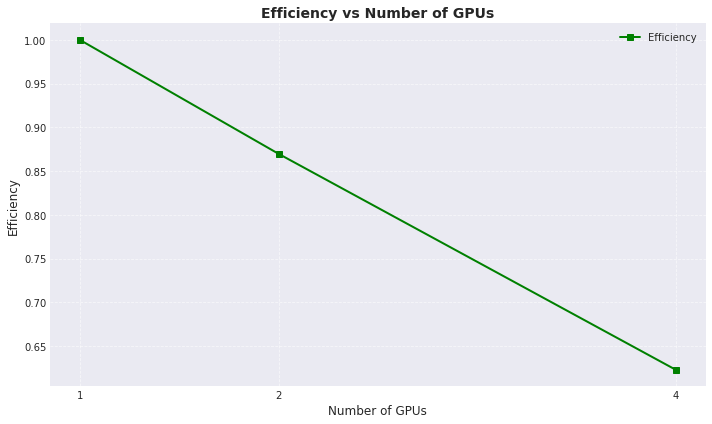

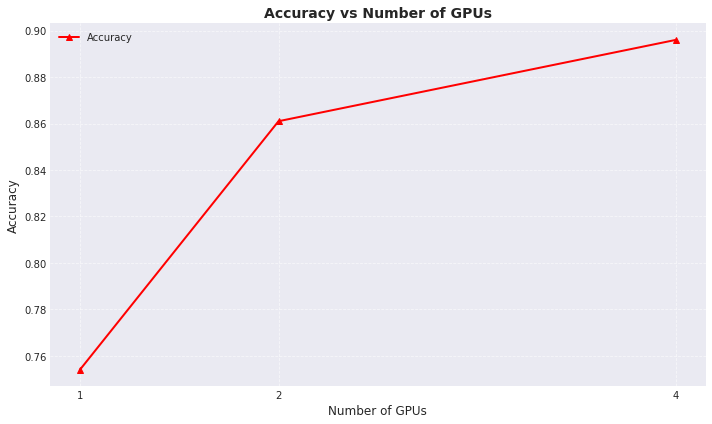

In [24]:
import json
import matplotlib.pyplot as plt

def load_logs(file_paths):
    """
    Load and parse JSON logs from a list of file paths.
    Handles empty lines and malformed JSON gracefully.

    Args:
        file_paths (list): List of file paths to JSON log files.

    Returns:
        dict: A dictionary containing parsed logs for each file.
    """
    logs = {}
    for file_path in file_paths:
        file_logs = []
        try:
            with open(file_path, 'r') as f:
                for line in f:
                    line = line.strip()
                    if line:  # Skip empty lines
                        try:
                            file_logs.append(json.loads(line))
                        except json.JSONDecodeError as e:
                            print(f"Error parsing line in {file_path}: {line}. Error: {e}")
        except FileNotFoundError:
            print(f"File {file_path} not found.")
        except Exception as e:
            print(f"Error reading {file_path}: {e}")
        logs[file_path] = file_logs
    return logs

# Load the JSON logs from files
file_paths = ['training_metrics_1gpu.json', 'training_metrics_GPU_2.json', 'training_metrics_GPU4.json']
logs = load_logs(file_paths)

# Extract data for plotting
num_gpus = []
total_times = []
accuracies = []
efficiencies = []

# Calculate training time for 1 GPU as the baseline
baseline_time = None

for file, log in logs.items():
    if log:  # Check if there are valid logs
        # Filter best rank for multi-GPU logs
        if 'GPU_2' in file or 'GPU4' in file:
            ranks = {}
            for entry in log:
                rank = entry.get('rank', -1)
                if rank not in ranks:
                    ranks[rank] = []
                ranks[rank].append(entry)
            # Select the rank with the best final accuracy
            best_rank = max(ranks.keys(), key=lambda r: ranks[r][-1]['accuracy'])
            log = ranks[best_rank]

        # Calculate total time and extract accuracy
        total_time = sum(entry['epoch_time'] for entry in log)
        accuracy = log[-1]['accuracy']  # Take the last epoch's accuracy

        # Extract number of GPUs from the file name
        if '1gpu' in file:
            gpus = 1
            baseline_time = total_time  # Set the baseline for efficiency calculation
        elif '2' in file:
            gpus = 2
        elif '4' in file:
            gpus = 4
        else:
            print(f"Could not determine GPU count for {file}")
            continue

        num_gpus.append(gpus)
        total_times.append(total_time)
        efficiencies.append(baseline_time / (gpus * total_time))  # Correct efficiency calculation
        accuracies.append(accuracy)

# Ensure plots are sorted by GPU count
sorted_indices = sorted(range(len(num_gpus)), key=lambda i: num_gpus[i])
num_gpus = [num_gpus[i] for i in sorted_indices]
total_times = [total_times[i] for i in sorted_indices]
accuracies = [accuracies[i] for i in sorted_indices]
efficiencies = [efficiencies[i] for i in sorted_indices]

# Plot Time vs. Number of GPUs
plt.figure(figsize=(10, 6))
plt.plot(num_gpus, total_times, label='Training Time', color='blue', linewidth=2, marker='o')
plt.xlabel('Number of GPUs', fontsize=12)
plt.ylabel('Training Time (s)', fontsize=12)
plt.title('Training Time vs Number of GPUs', fontsize=14, weight='bold')
plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks(num_gpus)  # Ensure only GPU counts are shown on x-axis
plt.tight_layout()
plt.legend()
plt.show()

# Plot Efficiency vs. Number of GPUs
plt.figure(figsize=(10, 6))
plt.plot(num_gpus, efficiencies, label='Efficiency', color='green', linewidth=2, marker='s')
plt.xlabel('Number of GPUs', fontsize=12)
plt.ylabel('Efficiency', fontsize=12)
plt.title('Efficiency vs Number of GPUs', fontsize=14, weight='bold')
plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks(num_gpus)
plt.tight_layout()
plt.legend()
plt.show()

# Plot Accuracy vs. Number of GPUs
plt.figure(figsize=(10, 6))
plt.plot(num_gpus, accuracies, label='Accuracy', color='red', linewidth=2, marker='^')
plt.xlabel('Number of GPUs', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.title('Accuracy vs Number of GPUs', fontsize=14, weight='bold')
plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks(num_gpus)
plt.tight_layout()
plt.legend()
plt.show()
